NOTES:
- 'checkpoint' file is not important if u load checkpoints directly by name
- Now train with minimun 5 keypoints per person
- Make sure to clean out temp/ before start training a new model

In [1]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-dcd43482-ebfe-77d9-e272-b82dec7daf48)


GPU 0: Tesla P100-PCIE-16GB 

In [2]:
!unzip ./drive/MyDrive/single-person-pose-estimation/dataset/tfrecords.zip

Archive:  ./drive/MyDrive/single-person-pose-estimation/dataset/tfrecords.zip
   creating: dataset/tfrecords/
   creating: dataset/tfrecords/valid/
  inflating: dataset/tfrecords/valid/file_valid_02-1551.tfrec  
  inflating: dataset/tfrecords/valid/file_valid_01-2048.tfrec  
  inflating: dataset/tfrecords/valid/file_valid_00-2048.tfrec  
   creating: dataset/tfrecords/train/
  inflating: dataset/tfrecords/train/file_train_21-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_00-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_47-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_50-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_25-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_20-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_62-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_52-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_36-2048.tfrec  
  inflating: dataset/tfrecords/train/file_trai

In [3]:
import sys
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
sys.path.append('/content/drive/MyDrive/single-person-pose-estimation')
from configs import default_config as cfg



---



---
Dataset


In [4]:
from dataset_builder import DatasetBuilder

In [5]:
ds_builder = DatasetBuilder(cfg)

Train dataset with 66 tfrecords and 134214 examples.
Valid dataset with 3 tfrecords and 5647 examples.




---



---
Model


In [6]:
from model.hourglass import create_hourglass_model

In [7]:
model = create_hourglass_model(cfg.NUM_KEYPOINTS, 
                                 cfg.HG_NUM_STACKS,
                                 cfg.HG_NUM_CHANNELS,
                                 cfg.IMAGE_SHAPE,
                                 cfg.HM_ACTIVATION)

Created Hourglass model:
    1. 2 stacks.
    2. 7034530 parameters. Call model.get_summary() for more detail.
    




---



---
TRAINER


In [8]:
from trainer import Trainer



---
Initial train (run once at the start)


In [ ]:
trainer = Trainer(model, ds_builder, epochs = 15, learning_rate = 1e-3, loss_str = 'IOU', config = cfg)

IOU


In [ ]:
trainer.train()

First training with:
    1. Current date 10-06-2022.
    2. Number of epochs 15.
    3. Batch size 16.
    4. Optimizer configs: {'name': 'Adam', 'learning_rate': 0.001, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}
    

Learning rate for epoch 1 is 0.0010000000474974513
Epoch 1/15
8388/8388 [==============================] - ETA: 0s - loss: 1.6702 - hg0_conv_1x1_predict_loss: 0.8502 - hg1_conv_1x1_predict_loss: 0.8200
Epoch 1: val_loss improved from inf to 1.57051, saving model to temp/checkpoints/best_val_loss_weights.ckpt
8388/8388 [==============================] - 2300s 271ms/step - loss: 1.6702 - hg0_conv_1x1_predict_loss: 0.8502 - hg1_conv_1x1_predict_loss: 0.8200 - val_loss: 1.5705 - val_hg0_conv_1x1_predict_loss: 0.8039 - val_hg1_conv_1x1_predict_loss: 0.7666

Learning rate for epoch 2 is 0.0010000000474974513
Epoch 2/15
8388/8388 [==============================] - ETA: 0s - loss: 1.5248 - hg0_conv_1x1_predict_loss: 0.7792 - hg1_conv_1x1_pr

TODO: need to change name of ckpts

In [ ]:
# to drive
!cp -r ./temp ./drive/MyDrive/single-person-pose-estimation



---
Resume train



In [9]:
# from drive
!cp -r ./drive/MyDrive/single-person-pose-estimation/temp ./

In [10]:
trainer = Trainer(model, ds_builder, epochs = 15, learning_rate = 0.25e-3, loss_str = 'IOU', config = cfg)

IOU


In [11]:
trainer.resume_training()

Loading weights from epoch 60
Loaded: E60_12-06-2022_cont.ckpt.index
---------------------------------------------------------
- Result from last train session number 4 at epoch 60:
loss: 1.321921944618225
hg0_conv_1x1_predict_loss: 0.6853196024894714
hg1_conv_1x1_predict_loss: 0.6365980505943298
val_loss: 1.3460044860839844
val_hg0_conv_1x1_predict_loss: 0.6909373998641968
val_hg1_conv_1x1_predict_loss: 0.6550670266151428
---------------------------------------------------------
- Best current val_loss at epoch 44:
loss: 1.3300670385360718
hg0_conv_1x1_predict_loss: 0.6874228119850159
hg1_conv_1x1_predict_loss: 0.6426457166671753
val_loss: 1.3286316394805908
val_hg0_conv_1x1_predict_loss: 0.6905380487442017
val_hg1_conv_1x1_predict_loss: 0.6380931735038757
---------------------------------------------------------
Resume training with:
    1. Train session number 5.
    2. Current date 12-06-2022.
    3. Resume training for 15 epochs, from epoch 60 to epoch 75.
    4. Batch size 16.
  

In [12]:
# to drive
!cp -r ./temp ./drive/MyDrive/single-person-pose-estimation




---


---


Test prediction

Should reset runtime


In [ ]:
# from drive
!cp -r ./drive/MyDrive/single-person-pose-estimation/temp ./

In [ ]:
trainer = Trainer(model, ds_builder, epochs = 15, learning_rate = 1e-3, loss_str = 'mse', config = cfg)

Mean Squared Error


In [ ]:
#loaded_model = trainer.get_best_weights_model()
loaded_model = trainer.get_lattest_weights_model()

Loading lattest trained weights from epoch 30
Loaded: E30_10-06-2022_cont.ckpt.index


In [ ]:
ds_train, ds_valid = ds_builder.build_datasets()

In [ ]:
loaded_model.evaluate(ds_valid, steps = np.ceil(ds_builder.num_valid_examples // cfg.BATCH_SIZE))

352/352 [==============================] - 41s 89ms/step - loss: 0.0025 - hg0_conv_1x1_predict_loss: 0.0013 - hg1_conv_1x1_predict_loss: 0.0013


[0.0025453504640609026, 0.0012540040770545602, 0.0012913461541756988]

In [ ]:
pred = loaded_model.predict(ds_valid.take(5))

In [ ]:
it = iter(ds_valid)

In [ ]:
images_batch, heatmaps_batch = next(it)

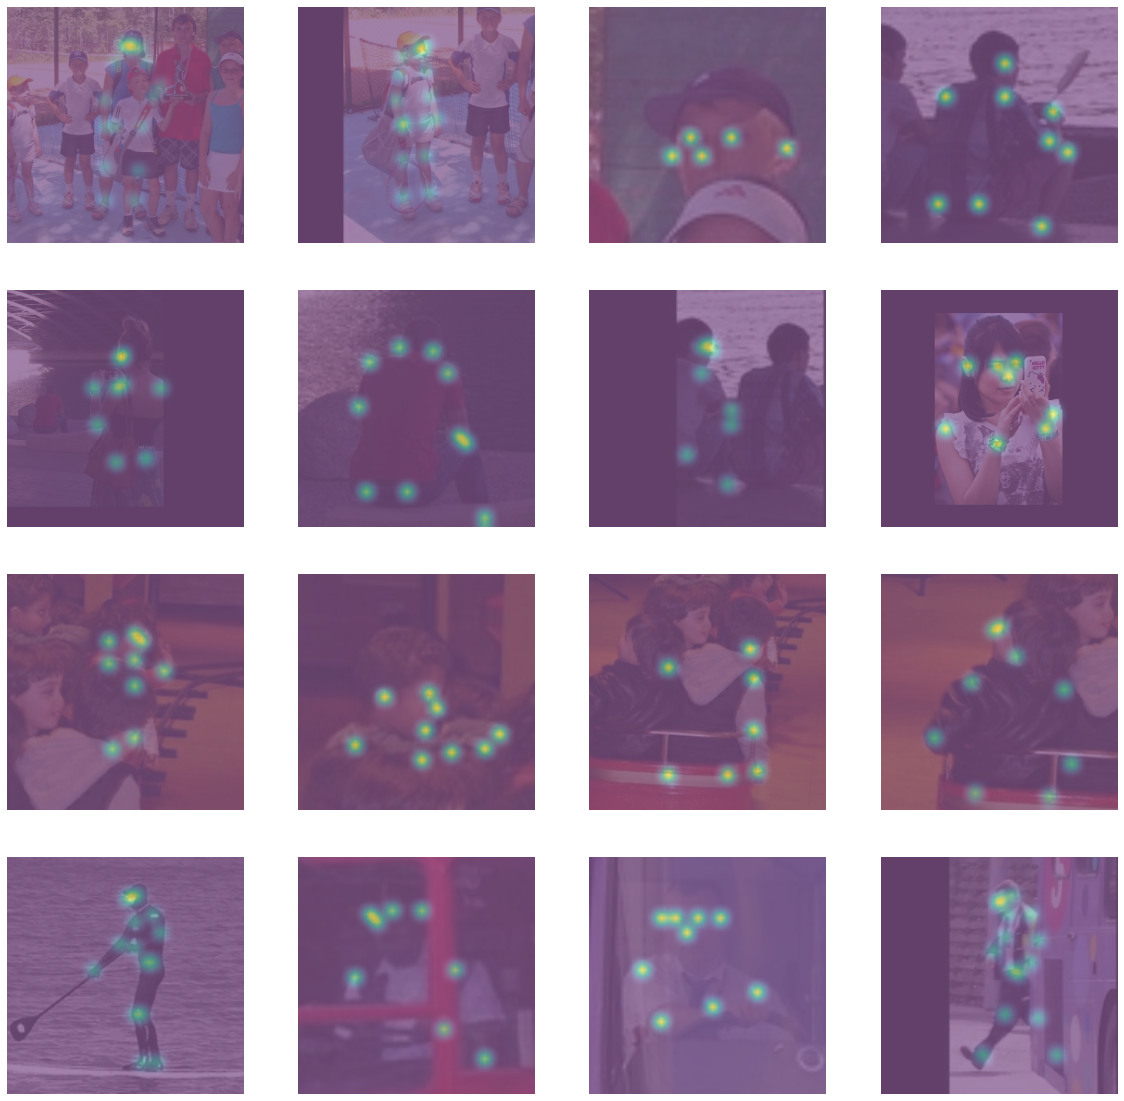

In [ ]:
#Truth ground
plt.figure(figsize=(20,20))
for i in range(16):
    ax = plt.subplot(16/4, 16/4, i + 1)
    plt.imshow(images_batch[i], cmap = 'gray', alpha = 0.5)
    h = tf.image.resize(heatmaps_batch[i], (256, 256))
    plt.imshow(tf.reduce_sum(h, axis = -1), alpha = 0.5)
    plt.axis("off")

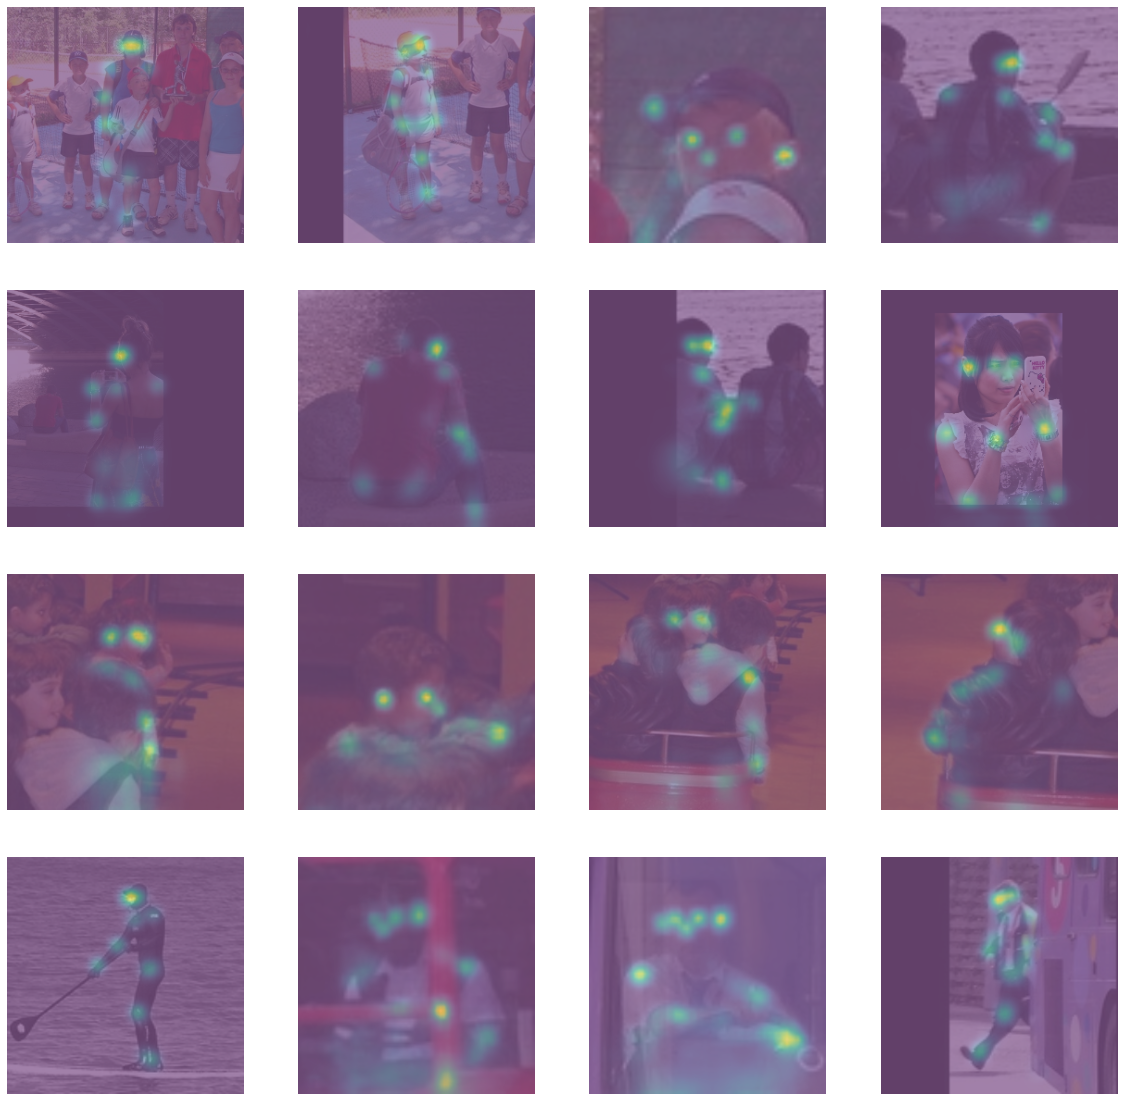

In [ ]:
plt.figure(figsize=(20,20))
for i in range(16):
    ax = plt.subplot(16/4, 16/4, i + 1)
    plt.imshow(images_batch[i], cmap = 'gray', alpha = 0.5)
    p = tf.image.resize(pred[-1][i+16], (256,256))
    plt.imshow(tf.reduce_sum(p, axis = -1), alpha = 0.5)
    plt.axis("off")



---

Save the whole model